In [2]:
%load_ext autoreload
%autoreload 2

# Imports
import tensorflow as tf
import recommender
from recommender import Recommender, FactorizationRecommender, BPRRecommender, ImplicitBPRRecommender, WalsRecommender, ImplicitWalsRecommender
from matrix_builder import ReportTechniqueMatrixBuilder
from tie import TechniqueInferenceEngine
from constants import PredictionMethod
import random
import math
import importlib
import pandas as pd
import numpy as np
import sklearn.manifold
import matplotlib.pyplot as plt

tf.config.run_functions_eagerly(True)

assert tf.executing_eagerly()

importlib.reload(recommender)


2024-07-05 09:52:56.353335: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-05 09:52:56.353649: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-05 09:52:56.356134: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-05 09:52:56.387707: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-05 09:52:56.913504: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

<module 'recommender' from '/home/mjturner/code/technique-inference-engine/models/recommender/__init__.py'>

In [3]:
validation_ratio = 0.1
test_ratio = 0.2

# data locations
dataset_filepath = "../data/combined_dataset_full_frequency.json"
enterprise_attack_filepath = "../enterprise-attack.json"

# make data
data_builder = ReportTechniqueMatrixBuilder(
    combined_dataset_filepath=dataset_filepath,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
data = data_builder.build()
# split into training and test data
train_and_validation_indices = frozenset(random.sample(data.indices, k=math.floor((1-test_ratio) * len(data.indices))))
validation_indices = frozenset(random.sample(tuple(train_and_validation_indices), k=math.floor((1-validation_ratio) * len(train_and_validation_indices))))
train_indices = frozenset(train_and_validation_indices).difference(validation_indices)
test_indices = frozenset(data.indices).difference(train_and_validation_indices)
training_data = data.mask(train_indices)
validation_data = data.mask(validation_indices)
test_data = data.mask(test_indices)

In [4]:
oilrig_techniques = {
    "T1047", "T1059.005", "T1124", "T1082",
    "T1497.001", "T1053.005", "T1027", "T1105",
    "T1070.004", "T1059.003", "T1071.001"
}

In [5]:

def test_multiple_embeding_dimensions(model_class: Recommender, method: PredictionMethod, out_file: str, **kwargs):
    """Runs model_class at multiple embedding dimensions and saves results.

    Runs each model for embedding dimensions 4, 8, 10, 16, 32, and 64.

    Args:
        model_class: A model on which to train at multiple embedding dimensions.
        out_file: filename for saving the results file.  Requires len(out_file) > 0
            and out_file is a valid csv filename.
        kwargs: Parameters mapped to values.

    Mutates:
        Saves model results, including embedding_dimension, hyperparameters,
        and precision, recall, and ndcg at 10, 20, 50, and 100 to out_file.
    """
    assert len(out_file) > 0

    results = []

    embedding_dimensions = (4,8,10,16,32,64)
    # for every embedding
    for embedding_dimension in embedding_dimensions:

        # make model
        model = model_class(
            m=training_data.m,
            n=training_data.n,
            k=embedding_dimension,
        )

        # make tie
        tie = TechniqueInferenceEngine(
            training_data=training_data,
            validation_data=validation_data,
            test_data=test_data,
            model=model,
            prediction_method=method,
            enterprise_attack_filepath=enterprise_attack_filepath,
        )

        # fit hyperparameters
        best_hyperparameters = tie.fit_with_cross_validation(**kwargs)

        # calculate precision, recall, ndcg
        run_stats = {
            "embedding_dimension": embedding_dimension,
            **best_hyperparameters
        }
        k_values = (10, 20, 50, 100)
        for k in k_values:
            run_stats[f"precision_at_{k}"] = tie.precision(k=k)
            run_stats[f"recall_at_{k}"] = tie.recall(k=k)
            run_stats[f"ndcg_at_{k}"] = tie.normalized_discounted_cumulative_gain(k=k)

        print(run_stats)
        results.append(run_stats)


    # save as csv
    results_dataframe = pd.DataFrame(results)
    results_dataframe.to_csv(out_file)

In [16]:
test_multiple_embeding_dimensions(
    model_class=WalsRecommender,
    method=PredictionMethod.COSINE,
    out_file="wals_model_results.csv",
    num_iterations=[20],
    c=[0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7],
    regularization_coefficient=[0.0, 0.0001, 0.001, 0.01]
)

{'embedding_dimension': 4, 'regularization_coefficient': 0.0, 'c': 0.5, 'num_iterations': 20, 'precision_at_10': 0.05996486745448738, 'recall_at_10': 0.3191653500762117, 'ndcg_at_10': 0.014108485192443017, 'precision_at_20': 0.03141967422548707, 'recall_at_20': 0.32867860657546566, 'ndcg_at_20': 0.02295209600045223, 'precision_at_50': 0.01430533375918237, 'recall_at_50': 0.3550723420769341, 'ndcg_at_50': 0.044463006816644376, 'precision_at_100': 0.008508463749600766, 'recall_at_100': 0.39553995847140255, 'ndcg_at_100': 0.0745173489039045}
{'embedding_dimension': 8, 'regularization_coefficient': 0.0, 'c': 0.005, 'num_iterations': 20, 'precision_at_10': 0.05994889811561801, 'recall_at_10': 0.3195821950592791, 'ndcg_at_10': 0.013412043917646218, 'precision_at_20': 0.031387735547748326, 'recall_at_20': 0.3284703512446247, 'ndcg_at_20': 0.022170551114881643, 'precision_at_50': 0.014056212072820184, 'recall_at_50': 0.3515898236168259, 'ndcg_at_50': 0.041549192119515285, 'precision_at_100': 0

In [6]:
test_multiple_embeding_dimensions(
    BPRRecommender,
    out_file="bpr_model_results.csv",
    num_iterations=[20*training_data.m*training_data.n],
    learning_rate=[0.00001, 0.00005, 0.0001, 0.001],
    regularization=[0., 0.0001, 0.001, 0.01],
)

/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/tech

{'embedding_dimension': 4, 'regularization': 0.0001, 'learning_rate': 0.0001, 'num_iterations': 76521640, 'precision_at_10': 0.01560204407537528, 'recall_at_10': 0.06050501513663635, 'ndcg_at_10': 0.07683413537968624, 'precision_at_20': 0.011992973490897476, 'recall_at_20': 0.09067910772439934, 'ndcg_at_20': 0.09634989967193944, 'precision_at_50': 0.0079112104758863, 'recall_at_50': 0.14733022592714648, 'ndcg_at_50': 0.12541038111253533, 'precision_at_100': 0.00527946343021399, 'recall_at_100': 0.1978219117723097, 'ndcg_at_100': 0.1456379374612586}


/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/tech

{'embedding_dimension': 8, 'regularization': 0.001, 'learning_rate': 0.0001, 'num_iterations': 76521640, 'precision_at_10': 0.012791440434366017, 'recall_at_10': 0.048452527172814557, 'ndcg_at_10': 0.06212604210714955, 'precision_at_20': 0.010012775471095497, 'recall_at_20': 0.07689506441974149, 'ndcg_at_20': 0.07903656541040587, 'precision_at_50': 0.006547428936442032, 'recall_at_50': 0.12561008986844754, 'ndcg_at_50': 0.10273975134585815, 'precision_at_100': 0.004500159693388694, 'recall_at_100': 0.17281461717597588, 'ndcg_at_100': 0.12142186359861892}


/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/tech

{'embedding_dimension': 10, 'regularization': 0.001, 'learning_rate': 0.0001, 'num_iterations': 76521640, 'precision_at_10': 0.011992973490897476, 'recall_at_10': 0.04644692238371199, 'ndcg_at_10': 0.05802910032592288, 'precision_at_20': 0.009374001916320665, 'recall_at_20': 0.0721340954731668, 'ndcg_at_20': 0.07385875110489287, 'precision_at_50': 0.006055573299265411, 'recall_at_50': 0.11468008558455581, 'ndcg_at_50': 0.09530259678856781, 'precision_at_100': 0.004227083998722453, 'recall_at_100': 0.16112090162064058, 'ndcg_at_100': 0.1135609038916972}


/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/tech

{'embedding_dimension': 16, 'regularization': 0.0001, 'learning_rate': 0.0001, 'num_iterations': 76521640, 'precision_at_10': 0.010923027786649633, 'recall_at_10': 0.04140103153989063, 'ndcg_at_10': 0.05513784313726271, 'precision_at_20': 0.008312040881507506, 'recall_at_20': 0.0647656160113604, 'ndcg_at_20': 0.06839756124757733, 'precision_at_50': 0.005416799744490578, 'recall_at_50': 0.10646787811167806, 'ndcg_at_50': 0.08773154884648639, 'precision_at_100': 0.0039603960396039604, 'recall_at_100': 0.15611050618282554, 'ndcg_at_100': 0.10676608984315174}


/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/tech

In [5]:
embedding_dimension = 10
k = 20
best_hyperparameters = {'gravity_coefficient': 0.001, 'regularization_coefficient': 0.001, 'num_iterations': 10, 'learning_rate': 1.0}

model = FactorizationRecommender(m=training_data.m, n=training_data.n, k=embedding_dimension)

tie = TechniqueInferenceEngine(
    training_data=training_data,
    validation_data=validation_data,
    test_data=test_data,
    model=model,
    prediction_method=PredictionMethod.COSINE,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
mse = tie.fit(**best_hyperparameters)
# mse = tie.fit_with_cross_validation(
#     learning_rate=[0.001, 0.01, 0.1, 1.0, 10., 20., 50., 100.],
#     num_iterations=[1000],
#     regularization_coefficient=[0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5],
#     gravity_coefficient=[0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5],
# )
print("Mean Squared Error", mse)
precision = tie.precision(k=k)
print("Precision", precision)
recall = tie.recall(k=k)
print("Recall", recall)
ndcg = tie.normalized_discounted_cumulative_gain(k=k)
print("Normalized Discounted Cumulative Gain", ndcg)


V <tf.Variable 'Variable:0' shape=(611, 10) dtype=float32, numpy=
array([[-1.1179849 , -0.9262015 ,  1.3654959 , ..., -1.7660879 ,
         2.5029678 ,  0.7442607 ],
       [-0.10877229, -0.22762883,  1.266221  , ...,  1.2434375 ,
         0.07606003, -0.62390465],
       [-0.0852319 ,  0.09279031, -1.4114041 , ..., -1.4059302 ,
         0.7559224 , -0.9448475 ],
       ...,
       [-1.3408604 , -1.0712773 , -0.768902  , ..., -0.21073838,
         1.3798618 ,  0.25823855],
       [-1.6484061 , -1.6502615 , -0.18298708, ...,  1.4674063 ,
        -2.4319723 , -0.69324434],
       [-0.2630491 , -0.37273243,  0.8600246 , ...,  0.83909637,
        -0.19260418,  1.5748355 ]], dtype=float32)>


V <tf.Variable 'Variable:0' shape=(611, 10) dtype=float32, numpy=
array([[-1.0893812 , -0.88374084,  1.3268396 , ..., -1.7432072 ,
         2.4527538 ,  0.71965635],
       [-0.10870928, -0.2282678 ,  1.2667834 , ...,  1.2427168 ,
         0.07604549, -0.6232688 ],
       [-0.08209909,  0.09425706, -1.4096586 , ..., -1.4004352 ,
         0.7529564 , -0.9430267 ],
       ...,
       [-1.3272604 , -1.0418779 , -0.74585396, ..., -0.20247978,
         1.328895  ,  0.22269927],
       [-1.6330534 , -1.6458112 , -0.18208316, ...,  1.4612074 ,
        -2.4245484 , -0.69911677],
       [-0.26191542, -0.37463787,  0.862028  , ...,  0.8406806 ,
        -0.19503804,  1.5731248 ]], dtype=float32)>


2024-07-05 09:53:28.683801: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


V <tf.Variable 'Variable:0' shape=(611, 10) dtype=float32, numpy=
array([[-1.0622082 , -0.8434472 ,  1.289808  , ..., -1.7216258 ,
         2.404947  ,  0.69618237],
       [-0.1086467 , -0.22890325,  1.2673433 , ...,  1.242001  ,
         0.07603108, -0.62263703],
       [-0.07901169,  0.09568332, -1.4079307 , ..., -1.3950486 ,
         0.7500339 , -0.94122833],
       ...,
       [-1.3139983 , -1.0140693 , -0.72360915, ..., -0.19499606,
         1.2804714 ,  0.18920922],
       [-1.6180415 , -1.6415204 , -0.18119931, ...,  1.455175  ,
        -2.417366  , -0.70492303],
       [-0.26079968, -0.37651467,  0.8640022 , ...,  0.842242  ,
        -0.1974348 ,  1.5714433 ]], dtype=float32)>
V <tf.Variable 'Variable:0' shape=(611, 10) dtype=float32, numpy=
array([[-1.0363536 , -0.8051502 ,  1.2542809 , ..., -1.7012311 ,
         2.3593526 ,  0.6737544 ],
       [-0.10858455, -0.22953518,  1.267901  , ...,  1.2412903 ,
         0.07601681, -0.62200934],
       [-0.07596876,  0.09706973, -1.40

In [7]:
new_report_predictions = tie.predict_for_new_report(oilrig_techniques, **best_hyperparameters)
print(new_report_predictions)

V <tf.Variable 'Variable:0' shape=(611, 10) dtype=float32, numpy=
array([[-0.8669771 , -0.55546737,  1.0132965 , ..., -1.570809  ,
         2.056959  ,  0.52440196],
       [-0.10810269, -0.23446646,  1.2722775 , ...,  1.2357793 ,
         0.07590737, -0.6171313 ],
       [-0.05312626,  0.1067994 , -1.393097  , ..., -1.3510264 ,
         0.725546  , -0.92596453],
       ...,
       [-1.2068088 , -0.8185137 , -0.55248725, ..., -0.15400518,
         0.9353086 , -0.03880112],
       [-1.4965435 , -1.6091493 , -0.17402616, ...,  1.40744   ,
        -2.362179  , -0.75438833],
       [-0.25151756, -0.39218634,  0.8805208 , ...,  0.85531795,
        -0.2174281 ,  1.5575391 ]], dtype=float32)>


embedding [[ 0.91330045]
 [-1.4900155 ]
 [-1.4514905 ]
 [-0.42837998]
 [ 0.33427244]
 [-0.03719686]
 [-0.59603447]
 [-0.67230105]
 [ 0.03931693]
 [ 1.3635713 ]]
predictions [[-7.2945189e-01]
 [-4.0934887e+00]
 [ 1.8841064e+00]
 [-9.4215250e-01]
 [-3.5169849e+00]
 [-2.1795278e+00]
 [ 1.6113402e+00]
 [-7.8954279e-01]
 [ 3.0979219e-01]
 [ 8.4803605e-01]
 [ 1.2197429e+00]
 [-2.1881847e+00]
 [-3.0553932e+00]
 [ 2.0259182e+00]
 [-3.1002650e+00]
 [ 2.5128474e+00]
 [-8.2666576e-01]
 [ 1.3185802e+00]
 [ 2.6984078e-01]
 [ 3.7746735e+00]
 [ 1.4725745e+00]
 [-2.2527978e-01]
 [-5.1689734e+00]
 [ 2.1939161e+00]
 [-1.4138305e+00]
 [ 2.9889209e+00]
 [-3.1438951e+00]
 [-3.8781261e-01]
 [ 5.8975327e-01]
 [ 9.8480892e-01]
 [ 2.7065239e+00]
 [-2.8358781e-01]
 [-4.1318269e+00]
 [-4.8000207e+00]
 [-1.6149925e+00]
 [-3.2124066e-01]
 [-1.9826101e+00]
 [ 3.6748722e+00]
 [ 3.6071889e+00]
 [ 3.7852764e-02]
 [-5.3332915e+00]
 [ 1.4110878e+00]
 [ 4.2303448e+00]
 [ 3.5193479e-01]
 [-1.5199584e+00]
 [ 3.6732106e+00]

In [13]:
# hyperparameters
embedding_dimension = 4
k = 20
best_hyperparameters = {'regularization': 0.0001, 'num_iterations': 256, 'learning_rate': 0.0001}
# best_hyperparameters["num_iterations"] = 20*training_data.m*training_data.n

model = BPRRecommender(m=training_data.m, n=training_data.n, k=embedding_dimension)

tie = TechniqueInferenceEngine(
    training_data=training_data,
    validation_data=validation_data,
    test_data=test_data,
    model=model,
    prediction_method=PredictionMethod.DOT,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
# mse = tie.fit_with_cross_validation(
#     learning_rate=[0.001, 0.005, 0.01, 0.02, 0.05],
#     num_iterations=[500 * 512],
#     regularization=[0, 0.0001, 0.001, 0.01],
# )
mse = tie.fit(**best_hyperparameters)
print("Mean Squared Error", mse)
precision = tie.precision(k=k)
print("Precision", precision)
recall = tie.recall(k=20)
print("Recall", recall)
ndcg = tie.normalized_discounted_cumulative_gain(k=k)
print("Normalized Discounted Cumulative Gain", ndcg)

Mean Squared Error 4.962237
Precision 0.0022037687639731717
Recall 0.020161774808568136
Normalized Discounted Cumulative Gain 0.015353215777474696


In [ ]:
# hyperparameters
embedding_dimension = 10
k = 20
best_hyperparameters = {'regularization': 0.0001, 'num_iterations': 256000, 'learning_rate': 0.005}

best_hyperparameters["num_iterations"] = 50
model = ImplicitBPRRecommender(m=training_data.m, n=training_data.n, k=embedding_dimension)

tie = TechniqueInferenceEngine(
    training_data=training_data,
    validation_data=validation_data,
    test_data=test_data,
    model=model,
    prediction_method=PredictionMethod.DOT,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
# mse = tie.fit_with_cross_validation(
#     learning_rate=[0.001, 0.005, 0.01, 0.02, 0.05],
#     num_iterations=[math.floor(500 * 512 / training_data.to_numpy().sum())],
#     regularization=[0, 0.0001, 0.001, 0.01],
# )
mse = tie.fit(**best_hyperparameters)
print("Mean Squared Error", mse)
precision = tie.precision(k=k)
print("Precision", precision)
recall = tie.recall(k=k)
print("Recall", recall)
ndcg = tie.normalized_discounted_cumulative_gain(k=k)
print("Normalized Discounted Cumulative Gain", ndcg)

2024-06-26 13:16:21.555967: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


  0%|          | 0/50 [00:00<?, ?it/s]

Mean Squared Error 1.0809024658129383
Precision 0.003768763973171511
Recall 0.02796446884968441
Normalized Discounted Cumulative Gain 0.027177323707043483


In [3]:
# hyperparameters
embedding_dimension = 10
k = 20

best_hyperparameters = {'regularization_coefficient': 0.05, 'c': 0.5, 'num_iterations': 20}

model = ImplicitWalsRecommender(m=training_data.m, n=training_data.n, k=embedding_dimension)

tie = TechniqueInferenceEngine(
    training_data=training_data,
    validation_data=validation_data,
    test_data=test_data,
    model=model,
    prediction_method=PredictionMethod.COSINE,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
mse = tie.fit(**best_hyperparameters)
# mse = tie.fit_with_cross_validation(
#     num_iterations=[20],
#     c=[0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7],
#     regularization_coefficient=[0.001, 0.005, 0.01, 0.02, 0.05]
# )
print("Mean Squared Error", mse)
precision = tie.precision(k=k)
print("Precision", precision)
recall = tie.recall(k=k)
print("Recall", recall)
ndcg = tie.normalized_discounted_cumulative_gain(k=k)
print("Normalized Discounted Cumulative Gain", ndcg)

2024-06-26 13:18:01.073155: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/mjturner/miniconda3/envs/py311/lib/python3.11/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 36 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/20 [00:00<?, ?it/s]

AttributeError: 'ImplicitWalsRecommender' object has no attribute '_U'

In [7]:
# hyperparameters
embedding_dimension = 4
k = 20

# best_hyperparameters = {'regularization_coefficient': 0.1, 'c': 0.5, 'num_iterations': 20}
# best_hyperparameters = {'regularization_coefficient': 0.0001, 'c': 0.3, 'num_iterations': 100}
best_hyperparameters = {'regularization_coefficient': 0.001, 'c': 0.1, "num_iterations": 20}
model = WalsRecommender(m=training_data.m, n=training_data.n, k=embedding_dimension)

tie = TechniqueInferenceEngine(
    training_data=training_data,
    validation_data=validation_data,
    test_data=test_data,
    model=model,
    prediction_method=PredictionMethod.COSINE,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
mse = tie.fit(**best_hyperparameters)
# mse = tie.fit_with_cross_validation(
#     num_iterations=[20],
#     c=[0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7],
#     regularization_coefficient=[0.001, 0.005, 0.01, 0.02, 0.05]
# )
print("Mean Squared Error", mse)
precision = tie.precision(k=k)
print("Precision", precision)
recall = tie.recall(k=k)
print("Recall", recall)
ndcg = tie.normalized_discounted_cumulative_gain(k=k)
print("Normalized Discounted Cumulative Gain", ndcg)

Mean Squared Error 0.6874669745202104
Precision 0.030868732034493772
Recall 0.3223539000453207
Normalized Discounted Cumulative Gain 0.021082271162900804


In [18]:
# TEMPORARY - GET EMBEDDINGS FOR FE
U = tie.get_U() # entity (report) ids
V = tie.get_V() # item (technique) embeddings

U_with_index = np.hstack((np.expand_dims(training_data.report_ids, axis=1), U))
V_with_index = np.hstack((np.expand_dims(training_data.technique_ids, axis=1), V))

print(U_with_index.shape)
print(V_with_index.shape)

[[ 0.00000000e+00  3.10272485e-01 -5.06079257e-01 ... -2.96728946e-02
   1.03696346e-01 -4.59698914e-03]
 [ 1.00000000e+00  2.34661356e-01 -3.45782340e-01 ... -8.81108269e-02
   7.32592419e-02  2.15996355e-01]
 [ 2.00000000e+00  4.81936446e-08  6.88791080e-10 ...  3.42836657e-08
  -7.81015075e-09 -4.81467985e-08]
 ...
 [ 6.25900000e+03  3.53572398e-01 -4.88738894e-01 ...  2.14364976e-02
   1.39371127e-01  1.01979606e-01]
 [ 6.26000000e+03 -5.61978075e-10 -3.23640350e-08 ... -7.43976116e-08
   8.64229861e-08  8.77083117e-09]
 [ 6.26100000e+03 -6.00948269e-08 -1.48262300e-08 ...  3.57593208e-08
  -9.07301079e-09  2.34565452e-08]]
(6262, 11)
(611, 11)


recalls [0.3087573406401257, 0.3257859760812914, 0.3458226653670225, 0.3745375233589626, 0.3949941633991787, 0.4110964558541681, 0.4219309973671012, 0.4317147374599419, 0.44042389049516534, 0.44770298702149547, 0.45387773687027355, 0.45797033624322875, 0.46304119765720547, 0.4679221448741617, 0.47182791494477766, 0.47617333685846847, 0.4791363202775644, 0.48264413250862803, 0.48577394889957126, 0.4883141430997783, 0.4904385260449852]


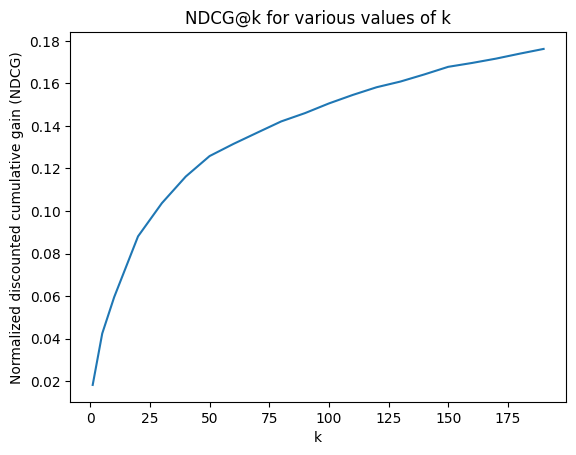

In [8]:
k_values = [1, 5] + list(range(10, 200, 10))
recalls = []
ndcgs = []
for k in k_values:
    # print("Mean Squared Error", mse)
    precision = tie.precision(k=k)
    # print("Precision", precision)
    recall = tie.recall(k=k)
    recalls.append(recall)
    # print("Recall", recall)
    ndcg = tie.normalized_discounted_cumulative_gain(k=k)
    ndcgs.append(ndcg)
    # print("Normalized Discounted Cumulative Gain", ndcg)

print("recalls", recalls)

plt.xlabel("k")
plt.ylabel("Normalized discounted cumulative gain (NDCG)")
plt.title("NDCG@k for various values of k")
plt.plot(k_values, ndcgs)

In [6]:
oilrig_techniques = {
    "T1047", "T1059.005", "T1124", "T1082",
    "T1497.001", "T1053.005", "T1027", "T1105",
    "T1070.004", "T1059.003", "T1071.001"
}
new_report_predictions = tie.predict_for_new_report(oilrig_techniques, c=0.5, regularization_coefficient=0.05, learning_rate=0.01, num_iterations=100)

print(new_report_predictions.sort_values(by="predictions", ascending=False).head(10))

TypeError: FactorizationRecommender.predict_new_entity() got an unexpected keyword argument 'c'

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 6262 samples in 0.003s...
[t-SNE] Computed neighbors for 6262 samples in 0.226s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6262
[t-SNE] Computed conditional probabilities for sample 2000 / 6262
[t-SNE] Computed conditional probabilities for sample 3000 / 6262
[t-SNE] Computed conditional probabilities for sample 4000 / 6262
[t-SNE] Computed conditional probabilities for sample 5000 / 6262
[t-SNE] Computed conditional probabilities for sample 6000 / 6262
[t-SNE] Computed conditional probabilities for sample 6262 / 6262
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 95.187531
[t-SNE] KL divergence after 10000 iterations: 0.847868


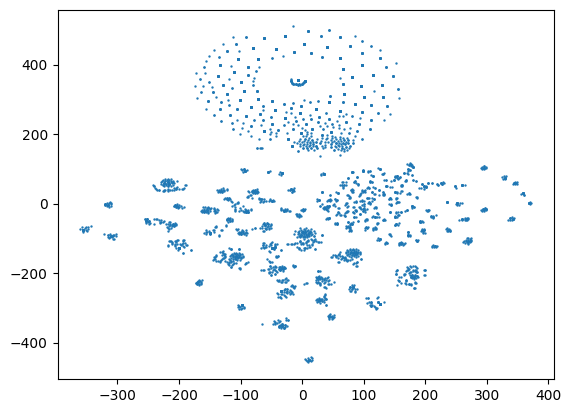

In [11]:
def make_tsne_embeddings(embeddings: np.ndarray) -> tuple[np.array, np.array]:
    """Create 2D representation of embeddings using t-SNE.

    Args:
        embeddings: an mxk array of m embeddings in k-dimensional space.

    Returns:
        A tuple of the form (x_1, x_2) where x_1 and x_2 are length m
        such that (x_1[i], x_2[i]) is the 2-dimensional point cotnaining the 2-dimensional
        repsresentation for embeddings[i, :].
    """
    tsne = sklearn.manifold.TSNE(
        n_components=2,
        perplexity=15,
        learning_rate="auto",
        # metric='cosine',
        # early_exaggeration=10.0,
        init='pca',
        verbose=True,
        n_iter=10000,
    )

    V_proj = tsne.fit_transform(embeddings)
    x = V_proj[:, 0]
    y = V_proj[:, 1]

    return x, y

U = tie.get_U()
x_1, x_2 = make_tsne_embeddings(U)

plt.scatter(x_1, x_2, s=0.5)
plt.show()